<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [18]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data_v3.csv'
column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Median 1st diff', 'Standard Dev 1st diff', 'Total Area', 'Power', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

Formato del dataset: (4471, 9)


In [ ]:
raw_dataset.tail() # muestra las últimas 5 filas por defecto

In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [19]:
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset

In [20]:
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

In [21]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Median,3577.0,1.363631,2.547375,-0.016128,0.236156,0.414905,0.977662,16.588235
Standard Dev,3577.0,0.115536,0.358677,0.000053,0.004119,0.018414,0.081729,7.603707
Max Value,3577.0,1.532847,2.736921,0.005211,0.271320,0.457109,1.202866,19.523381
Min Value,3577.0,1.179364,2.393690,-1.437095,0.183774,0.352843,0.768498,16.218651
Median 1st diff,3577.0,0.004767,0.013899,0.000003,0.000164,0.000757,0.003444,0.261088
Standard Dev 1st diff,3577.0,0.000053,0.005151,-0.056409,-0.000334,-0.000015,0.000149,0.094267
Total Area,3577.0,161.822695,301.113486,-2.535290,28.399810,49.368208,118.012661,1982.833994
Power,3577.0,1006.783899,3515.153786,0.000904,7.012474,21.432180,125.211428,33314.307095


### 3.2. Normalización y estandarización de todos los datos

In [22]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3577, 8)
Formato del dataset de test: (894, 8)


In [23]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Median,3577.0,3.674879e-17,1.0,-0.541640,-0.442603,-0.372433,-0.151517,5.976585
Standard Dev,3577.0,-2.483026e-17,1.0,-0.321968,-0.310634,-0.270779,-0.094256,20.877170
Max Value,3577.0,3.724539e-17,1.0,-0.558159,-0.460929,-0.393047,-0.120567,6.573276
Min Value,3577.0,-2.284384e-17,1.0,-1.093065,-0.415923,-0.345292,-0.171646,6.282887
Median 1st diff,3577.0,-4.568768e-17,1.0,-0.342779,-0.331210,-0.288535,-0.095231,18.442228
Standard Dev 1st diff,3577.0,-3.972842e-18,1.0,-10.960439,-0.075167,-0.013184,0.018685,18.289028
Total Area,3577.0,-9.361008e-17,1.0,-0.545834,-0.443098,-0.373462,-0.145493,6.047591
Power,3577.0,-7.200776e-18,1.0,-0.286412,-0.284418,-0.280315,-0.250792,9.190927


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [24]:
from keras import Sequential, layers, activations

def build_model(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(9, 4, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 8, 27)               │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_4 (ELU)                          │ (None, 8, 27)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 27)               │             108 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 6, 22)               │           1,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_5 (ELU)                          │ (None, 6, 22)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 22)               │              88 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 3, 18)               │           1,602 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_6 (ELU)                          │ (None, 3, 18)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 18)               │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 3, 9)                │             657 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_7 (ELU)                          │ (None, 3, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 9)                │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 22)                  │             616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,087 (19.87 KB)

 Trainable params: 4,935 (19.28 KB)

 Non-trainable params: 152 (608.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [25]:
EPOCHS = 700
history = model.fit(normed_train_data, train_labels, batch_size=350,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
695,0.700454,0.762008,0.544731,0.701786,0.892675,0.615922,0.748252,0.697180,0.646833,0.787383,695
696,0.708843,0.762008,0.545362,0.733871,0.826803,0.614525,0.748252,0.694767,0.644487,0.792056,696
697,0.710591,0.762008,0.542726,0.724387,0.855196,0.628492,0.748252,0.695763,0.648352,0.827103,697
698,0.702901,0.762008,0.547949,0.710393,0.873367,0.631285,0.748252,0.686494,0.651852,0.822430,698
699,0.716183,0.762008,0.542684,0.730228,0.854628,0.624302,0.748252,0.696901,0.643761,0.831776,699


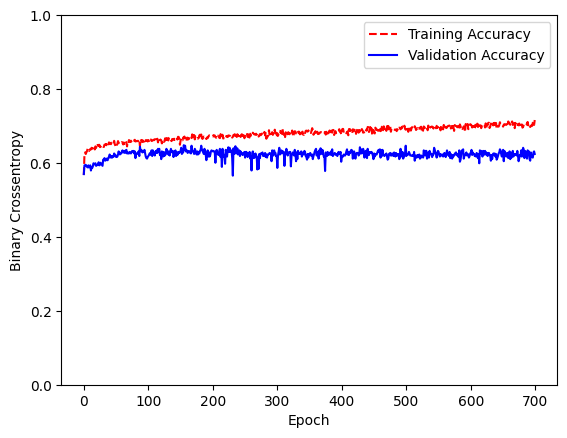

In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [30]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.6387 - f1_score: 0.7618 - loss: 0.6656 - precision: 0.6638 - recall: 0.8364
Test accuracy: 63.87%
Test loss: 0.666
